In [1]:
setwd('/import/wgcna/')

In [2]:
library(WGCNA)
library(reshape2)
library(stringr)
options(stringsAsFactors = FALSE)
# 打开多线程
enableWGCNAThreads()
exprMat <- "./fpkm.txt"
type = "unsigned"
corType = "pearson"
corFnc = ifelse(corType=="pearson", cor, bicor)
maxPOutliers = ifelse(corType=="pearson",1,0.05)
robustY = ifelse(corType=="pearson",T,F)

Warning message:
"package 'WGCNA' was built under R version 4.2.3"
Loading required package: dynamicTreeCut

Warning message:
"package 'dynamicTreeCut' was built under R version 4.2.3"
Loading required package: fastcluster

Warning message:
"package 'fastcluster' was built under R version 4.2.3"

Attaching package: 'fastcluster'


The following object is masked from 'package:stats':

    hclust





Attaching package: 'WGCNA'


The following object is masked from 'package:stats':

    cor


Warning message:
"package 'reshape2' was built under R version 4.2.3"
Warning message:
"package 'stringr' was built under R version 4.2.3"


Allowing parallel execution with up to 255 working processes.


In [3]:
library(tidyverse)
library(clusterProfiler)

Warning message in system("timedatectl", intern = TRUE):
"running command 'timedatectl' had status 1"
-- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v ggplot2 3.4.3     v purrr   1.0.1
v tibble  3.2.1     v dplyr   1.1.2
v tidyr   1.3.0     v forcats 1.0.0
v readr   2.1.4     
Warning message:
"package 'ggplot2' was built under R version 4.2.3"
Warning message:
"package 'tibble' was built under R version 4.2.3"
Warning message:
"package 'tidyr' was built under R version 4.2.3"
Warning message:
"package 'readr' was built under R version 4.2.3"
Warning message:
"package 'purrr' was built under R version 4.2.3"
Warning message:
"package 'dplyr' was built under R version 4.2.3"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Registered S3 methods overwritten by 'treeio':
  method              from    
  MRCA.phylo          tidytree
  MRCA.treedata 

In [4]:
dataExpr <- read.table(exprMat, sep='\t', header=T, 
                     quote="", comment="", check.names=F)

In [5]:
head(dataExpr,2)

,name,C1,C2,C3,C4,C5,C6,H2,H3,H4,H5,H6,H7,H8,H10,H11,H12
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSMUSG00000000001,12.8429983,13.6373783,14.5687033,13.6079433,13.3565464,12.5692320,12.2666509,12.4021613,12.5118821,12.7602605,12.3101131,11.6977462,9.6142045,10.8069392,12.6332811,11.525586
2,ENSMUSG00000000028,0.7133845,0.5275794,0.4607862,0.5387616,0.5803565,0.5764883,0.4797932,0.4863987,0.4220034,0.5299264,0.5556418,0.4905815,0.4612743,0.4479403,0.6343465,0.668019


In [6]:
name <- bitr(dataExpr$name,fromType = 'ENSEMBL',toType = 'SYMBOL',OrgDb = 'org.Mm.eg.db')
count2 <- right_join(name,dataExpr,by=c("ENSEMBL"="name"))



'select()' returned 1:many mapping between keys and columns

Warning message in bitr(dataExpr$name, fromType = "ENSEMBL", toType = "SYMBOL", :
"33.53% of input gene IDs are fail to map..."


In [7]:
count3 = count2[!duplicated(count2$SYMBOL),]

In [8]:
count3 = na.omit(count3)

In [9]:
rownames(count3) = count3[,2]

In [10]:
count3 = count3[,-c(1,2)]

In [11]:
head(count3,2)

,C1,C2,C3,C4,C5,C6,H2,H3,H4,H5,H6,H7,H8,H10,H11,H12
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Gnai3,12.8429983,13.6373783,14.5687033,13.6079433,13.3565464,12.5692320,12.2666509,12.4021613,12.5118821,12.7602605,12.3101131,11.6977462,9.6142045,10.8069392,12.6332811,11.525586
Cdc45,0.7133845,0.5275794,0.4607862,0.5387616,0.5803565,0.5764883,0.4797932,0.4863987,0.4220034,0.5299264,0.5556418,0.4905815,0.4612743,0.4479403,0.6343465,0.668019


In [12]:
dataExpr = count3

In [13]:
m.mad <- apply(dataExpr,1,mad)
dataExprVar <- dataExpr[which(m.mad > 
                 max(quantile(m.mad, probs=seq(0, 1, 0.25))[2],0.01)),]

dataExpr <- as.data.frame(t(dataExprVar))
gsg = goodSamplesGenes(dataExpr, verbose = 3)

 Flagging genes and samples with too many missing values...
  ..step 1


In [14]:
if (!gsg$allOK){
  # Optionally, print the gene and sample names that were removed:
  if (sum(!gsg$goodGenes)>0) 
    printFlush(paste("Removing genes:", 
                     paste(names(dataExpr)[!gsg$goodGenes], collapse = ",")));
  if (sum(!gsg$goodSamples)>0) 
    printFlush(paste("Removing samples:", 
                     paste(rownames(dataExpr)[!gsg$goodSamples], collapse = ",")));
  # Remove the offending genes and samples from the data:
  dataExpr = dataExpr[gsg$goodSamples, gsg$goodGenes]
}

In [15]:
nGenes = ncol(dataExpr)
nSamples = nrow(dataExpr)
dim(dataExpr)

[1]    16 18140

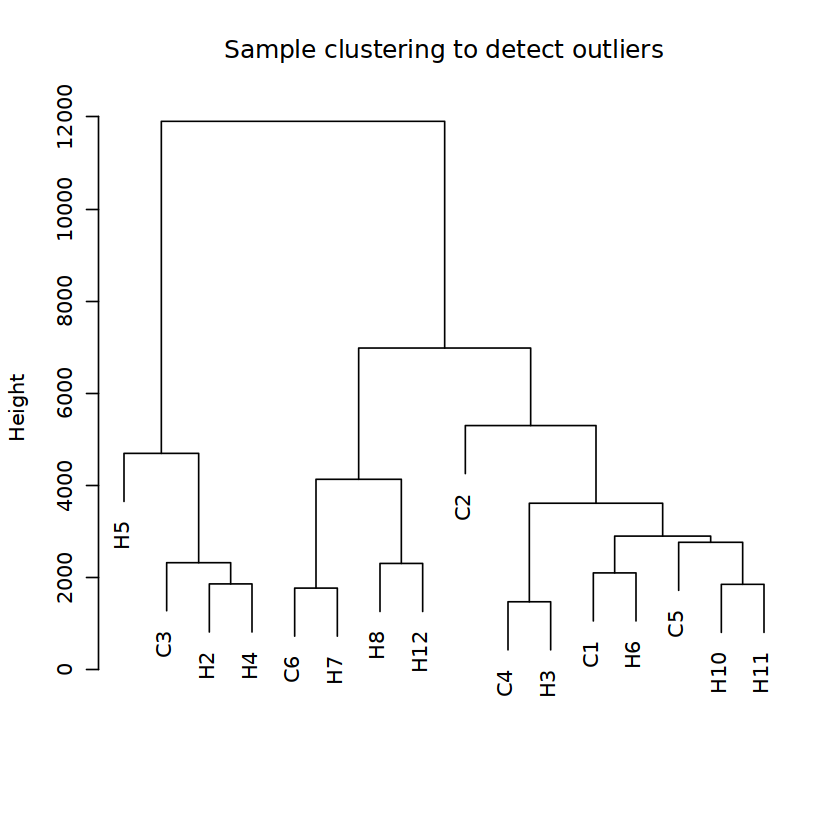

In [16]:
sampleTree = hclust(dist(dataExpr), method = "average")
plot(sampleTree, main = "Sample clustering to detect outliers", sub="", xlab="")

In [17]:
powers = c(c(1:10), seq(from = 12, to=30, by=2))
sft = pickSoftThreshold(dataExpr, powerVector=powers, 
                        networkType=type, verbose=5)

pickSoftThreshold: will use block size 2466.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 2466 of 18140
   ..working on genes 2467 through 4932 of 18140
   ..working on genes 4933 through 7398 of 18140
   ..working on genes 7399 through 9864 of 18140
   ..working on genes 9865 through 12330 of 18140
   ..working on genes 12331 through 14796 of 18140
   ..working on genes 14797 through 17262 of 18140
   ..working on genes 17263 through 18140 of 18140
   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.0371  0.316          0.565 5220.00  5120.000   7990
2      2   0.6430 -0.770          0.844 2290.00  2070.000   4900
3      3   0.8640 -1.040          0.918 1230.00   991.000   3430
4      4   0.8910 -1.130          0.929  744.00   523.000   2580
5      5   0.8870 -1.190          0.925  489.00   294.000   2040
6      6   0.8710 -1.240          0.918  341.00   175.000   1670
7      7   0.8730 -1.260          0.928

In [18]:
options(repr.plot.width = 9)

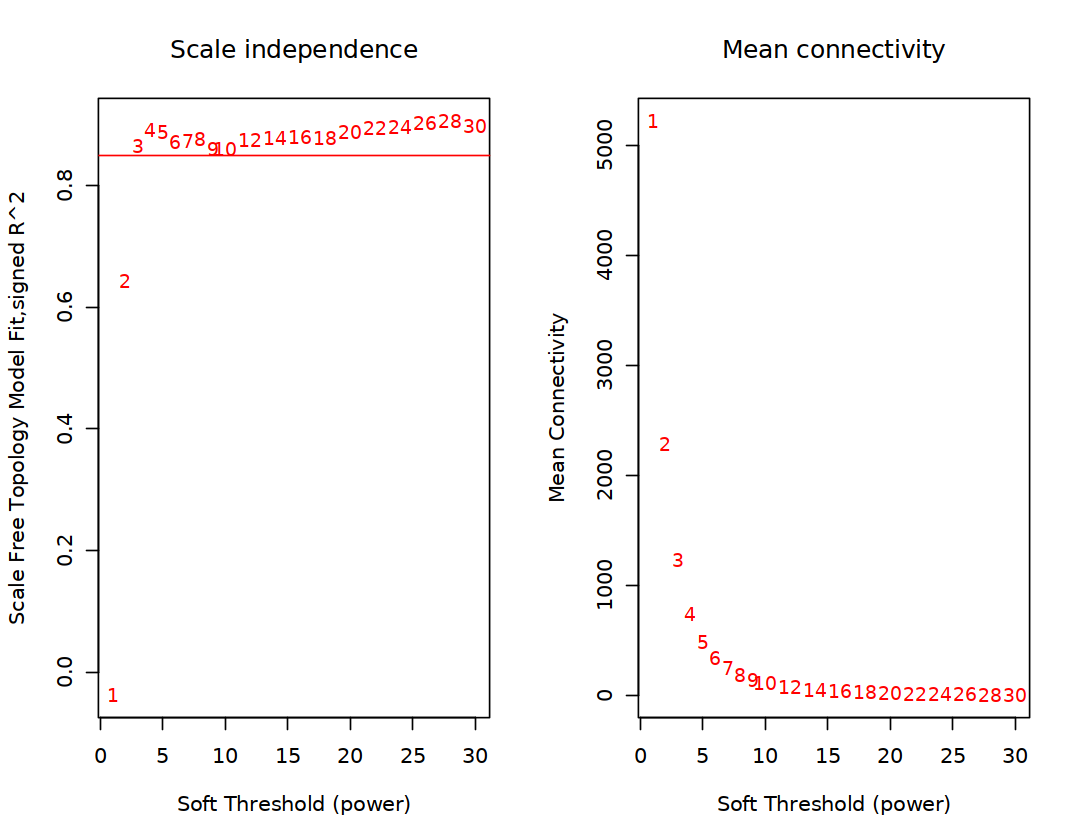

In [19]:
par(mfrow = c(1,2))
cex1 = 0.9
# 横轴是Soft threshold (power)，纵轴是无标度网络的评估参数，数值越高，
# 网络越符合无标度特征 (non-scale)
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     xlab="Soft Threshold (power)",
     ylab="Scale Free Topology Model Fit,signed R^2",type="n",
     main = paste("Scale independence"))
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
     labels=powers,cex=cex1,col="red")
# 筛选标准。R-square=0.85
abline(h=0.85,col="red")
plot(sft$fitIndices[,1], sft$fitIndices[,5],
     xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
     main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, 
     cex=cex1, col="red")

In [20]:
power = sft$powerEstimate
power

[1] 3

In [21]:
if (is.na(power)){
  power = ifelse(nSamples<20, ifelse(type == "unsigned", 9, 18),
          ifelse(nSamples<30, ifelse(type == "unsigned", 8, 16),
          ifelse(nSamples<40, ifelse(type == "unsigned", 7, 14),
          ifelse(type == "unsigned", 6, 12))       
          )
          )
}

In [22]:
net = blockwiseModules(dataExpr, power = power, maxBlockSize = nGenes,
                       TOMType = type, minModuleSize = 30,
                       reassignThreshold = 0, mergeCutHeight = 0.25,
                       numericLabels = TRUE, pamRespectsDendro = FALSE,
                       saveTOMs=TRUE, corType = corType, 
                       maxPOutliers=maxPOutliers, loadTOMs=TRUE,
                       saveTOMFileBase = paste0(exprMat, ".tom"),
                       verbose = 3)

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will use 128 parallel threads.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
   ..saving TOM for block 1 into file ./fpkm.txt.tom-block.1.RData
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
     ..removing 603 genes from module 1 because their KME is too low.
     ..removing 671 genes from module 2 because their KME is too low.
     ..removing 312 genes from module 3 because their KME is too low.
     ..removing 48 genes from module 4 because their KME is too low.
     ..removing 190 genes from module 5 because their KME is too low.
     ..removing 33 genes from module 6 because their KME is too low.
     ..removing 53 genes from modu

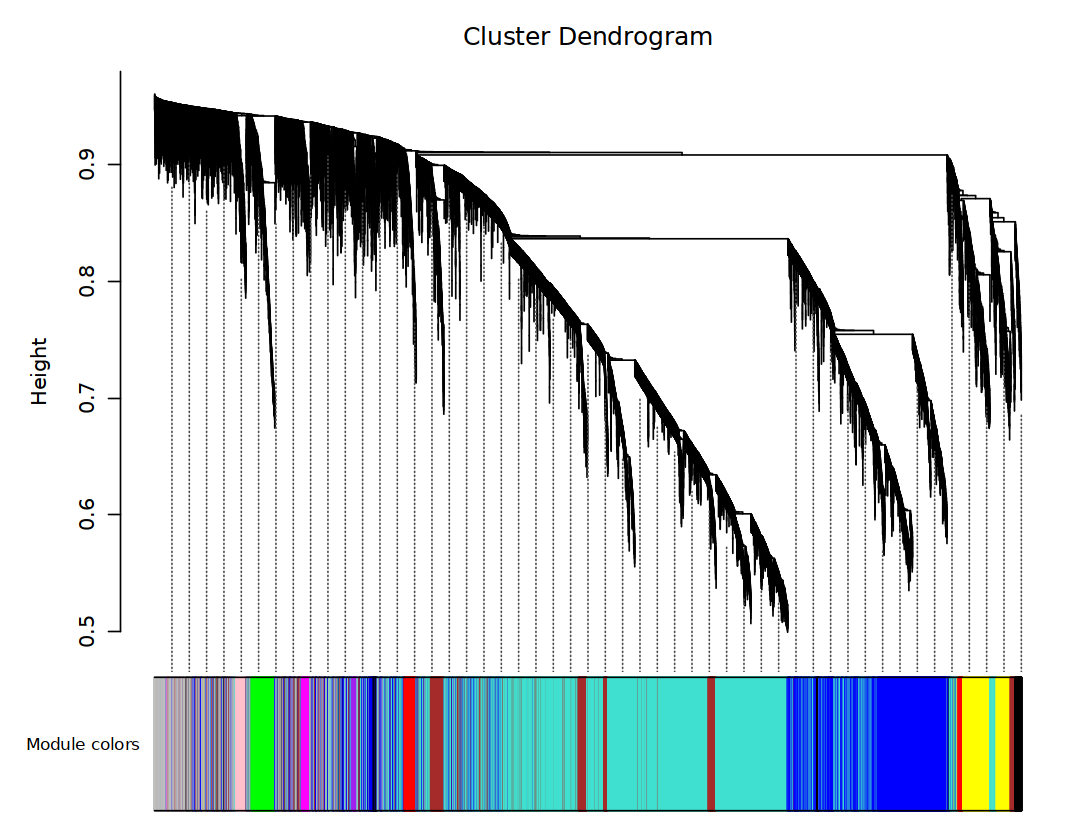

In [23]:
moduleLabels = net$colors
moduleColors = labels2colors(moduleLabels)
plotDendroAndColors(net$dendrograms[[1]], moduleColors[net$blockGenes[[1]]],
                    "Module colors",
                    dendroLabels = FALSE, hang = 0.03,
                    addGuide = TRUE, guideHang = 0.05)

In [24]:
MEs = net$MEs
MEs_col = MEs
colnames(MEs_col) = paste0("ME", labels2colors(
  as.numeric(str_replace_all(colnames(MEs),"ME",""))))
MEs_col = orderMEs(MEs_col)

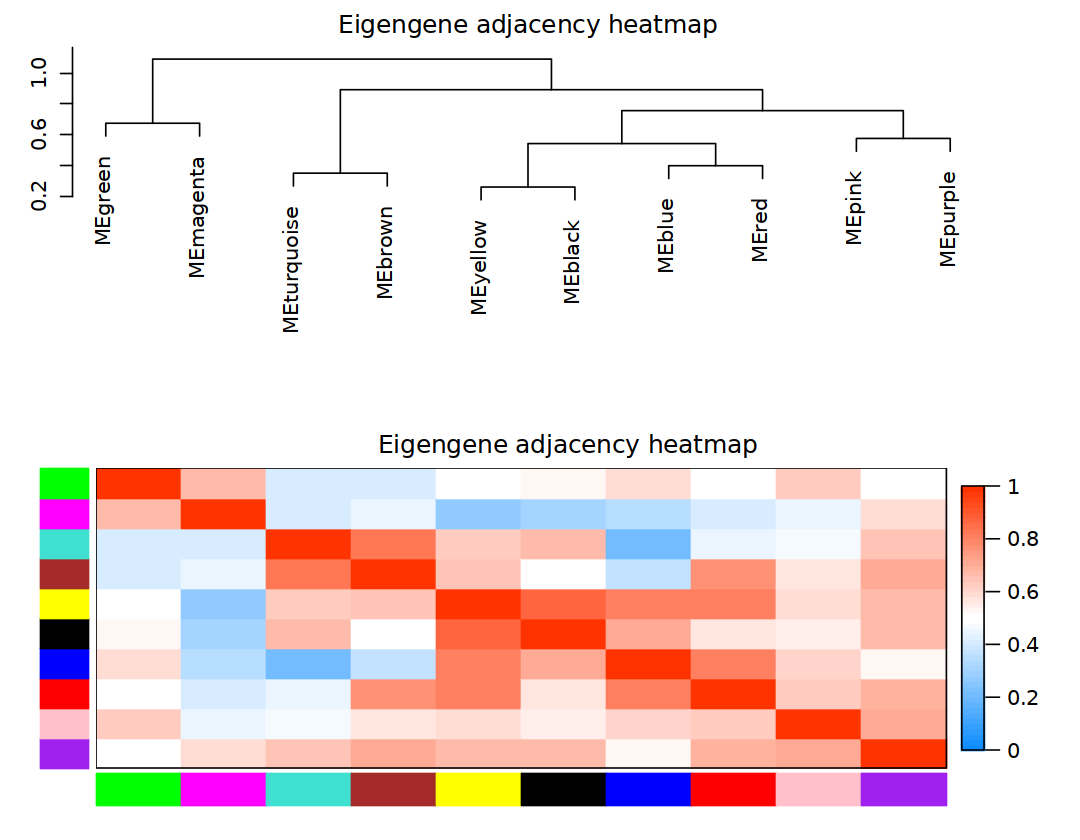

In [25]:
plotEigengeneNetworks(MEs_col, "Eigengene adjacency heatmap", 
                      marDendro = c(3,3,2,4),
                      marHeatmap = c(3,4,2,2), plotDendrograms = T, 
                      xLabelsAngle = 90)

In [26]:
TOM = TOMsimilarityFromExpr(dataExpr, power=power, corType=corType, networkType=type)

TOM calculation: adjacency..
..will use 128 parallel threads.
 Fraction of slow calculations: 0.000000
..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


In [27]:
# TOM <- as.matrix(TOM)
# dissTOM = 1-TOM

In [28]:
# plotTOM = dissTOM^7
# diag(plotTOM) = NA
# TOMplot(plotTOM, net$dendrograms, moduleColors, 
#         main = "Network heatmap plot, all genes")

In [29]:
# probes = colnames(dataExpr)
# dimnames(TOM) <- list(probes, probes)
# cyt = exportNetworkToCytoscape(TOM,
#              edgeFile = paste(exprMat, ".edges.txt", sep=""),
#              nodeFile = paste(exprMat, ".nodes.txt", sep=""),
#              weighted = TRUE, threshold = 0,
#              nodeNames = probes, nodeAttr = moduleColors)

In [30]:
trait <- "./trait.txt"
if(trait != "") {
  traitData <- read.table(file=trait, sep='\t', header=T, row.names=1,
                          check.names=FALSE, comment='',quote="")
  sampleName = rownames(dataExpr)
  traitData = traitData[match(sampleName, rownames(traitData)), ]
}
if (corType=="pearsoon") {
  modTraitCor = cor(MEs_col, traitData, use = "p")
  modTraitP = corPvalueStudent(modTraitCor, nSamples)
} else {
  modTraitCorP = bicorAndPvalue(MEs_col, traitData, robustY=robustY)
  modTraitCor = modTraitCorP$bicor
  modTraitP   = modTraitCorP$p
}
textMatrix = paste(signif(modTraitCor, 2), "\n(", signif(modTraitP, 1), ")", sep = "")
dim(textMatrix) = dim(modTraitCor)

Warning message in bicor(x, y, use = use, ...):
"bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD."


In [31]:
modTraitCor

,Control,PTSD-,PTSD+
MEgreen,0.35514083,-0.27290782,-0.11104465
MEmagenta,0.08854012,0.01575889,-0.10263530
MEturquoise,-0.22047442,-0.58927713,0.74753991
MEbrown,-0.58994504,-0.26461815,0.82662671
MEyellow,0.11113394,-0.21530671,0.08144224
MEblack,0.36523965,-0.34450010,-0.05710939
MEblue,0.24958676,0.28289398,-0.50261483
MEred,-0.34660729,0.18481693,0.18130201
MEpink,0.19008076,-0.19952036,-0.01162432
MEpurple,-0.20820557,-0.06312595,0.26466713


In [32]:
options(repr.plot.height = 8,repr.plot.width = 7)

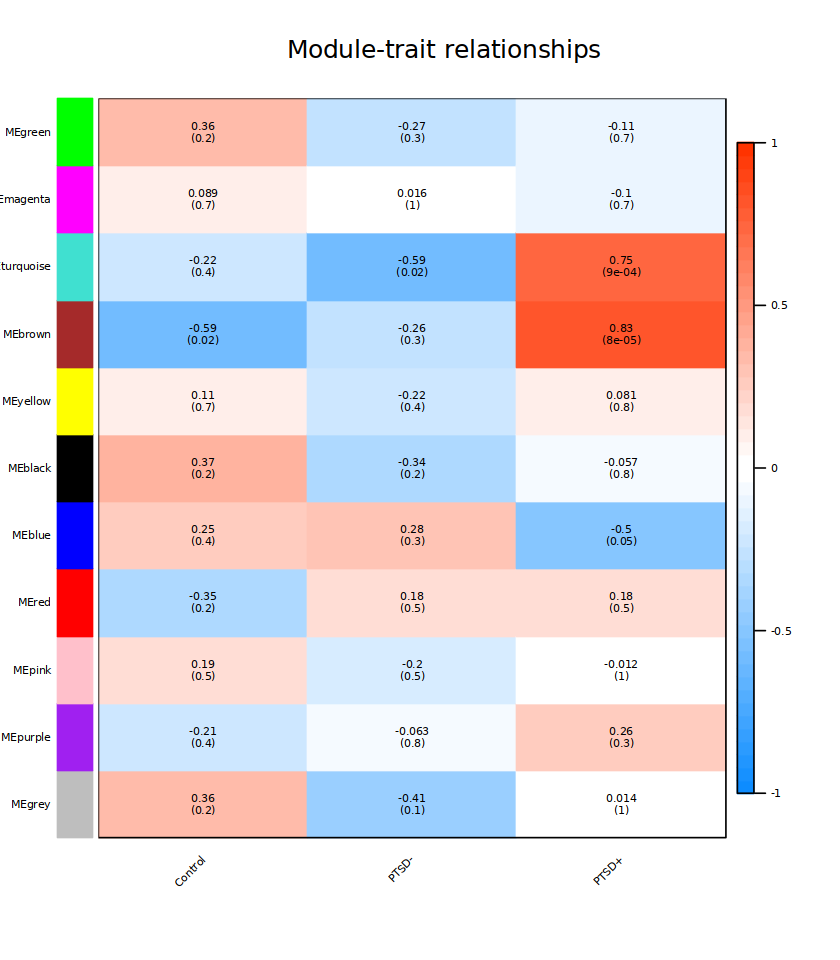

In [33]:
labeledHeatmap(Matrix = modTraitCor, xLabels = colnames(traitData), 
               yLabels = colnames(MEs_col), 
               cex.lab = 0.5, 
               ySymbols = colnames(MEs_col), colorLabels = FALSE, 
                colors = blueWhiteRed(50),
               textMatrix = textMatrix, setStdMargins = FALSE, 
               cex.text = 0.5, zlim = c(-1,1),
               main = paste("Module-trait relationships"))

In [34]:
dat = dataExpr

In [35]:
nSamples <- nrow(dat)
#计算MM值和GS值
modNames <- substring(colnames(MEs_col), 3) ##切割，从第三个字符开始保存
geneModuleMembership <- as.data.frame(cor(dat, MEs, use = "p")) #算出每个模块跟基因的Pearson相关系数矩阵
MMPvalue <- as.data.frame(corPvalueStudent(as.matrix(geneModuleMembership), nSamples)) #计算MM值对应的P值
names(geneModuleMembership) <- paste("MM", modNames, sep="")
names(MMPvalue) <- paste("p.MM", modNames, sep="")
geneTraitSignificance <- as.data.frame(cor(dat, traitData, use = "p")) 

In [36]:
GSPvalue <- as.data.frame(corPvalueStudent(as.matrix(geneTraitSignificance), nSamples))
names(geneTraitSignificance) <- paste("GS.", colnames(traitData), sep="")
names(GSPvalue) <- paste("p.GS.", colnames(traitData), sep="")

In [37]:

module <- "brown"
column <- match(module, modNames)  ##在所有模块中匹配选择的模块，返回所在的位置
brown_moduleGenes <- names(net$colors)[which(moduleColors == module)]
MM <- abs(geneModuleMembership[brown_moduleGenes, column])
GS <- abs(geneTraitSignificance[brown_moduleGenes, 1])

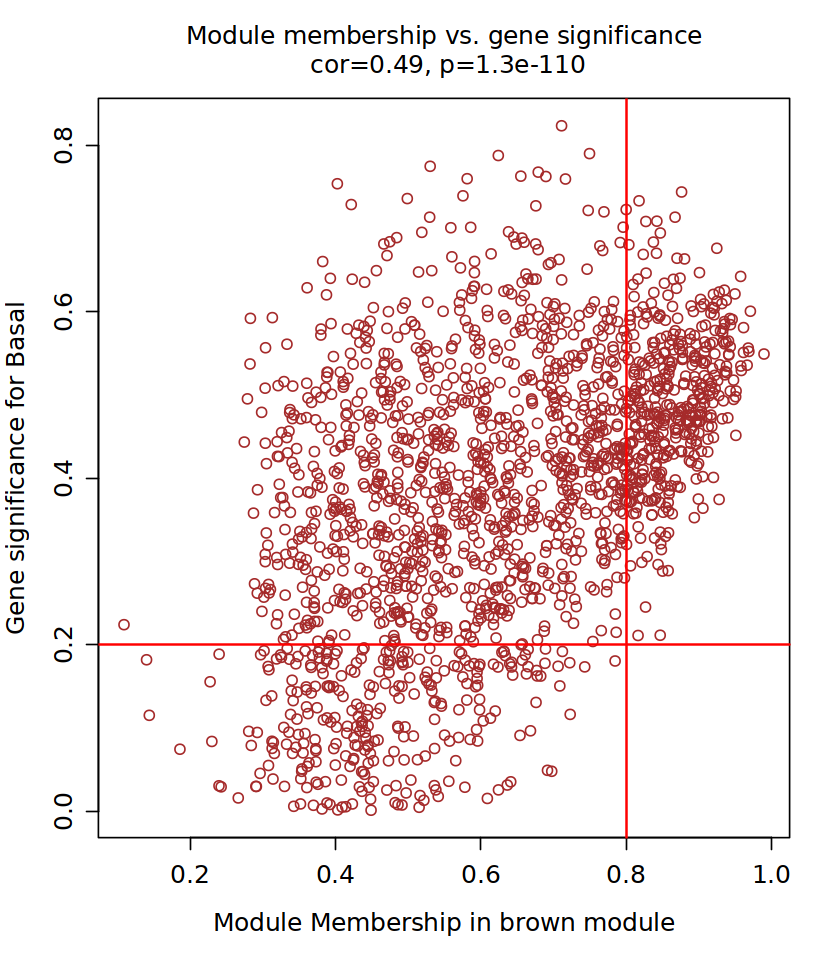

In [38]:
verboseScatterplot(MM, GS,
                   xlab = paste("Module Membership in", module, "module"),
                   ylab = "Gene significance for Basal",
                   main = paste("Module membership vs. gene significance\n"),
                   cex.main = 1.2, cex.lab = 1.2, cex.axis = 1.2, col = module)
abline(h=0.2,v=0.8,col="red",lwd=1.5)

In [39]:
brown_hub <- brown_moduleGenes[(GS > 0.2 & MM > 0.8)]
length(brown_hub)

[1] 434

In [40]:
write.csv(brown_hub,'brown_hub_gene.csv')

Loading required package: AnnotationDbi

Warning message:
"package 'AnnotationDbi' was built under R version 4.2.2"
Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:dplyr':

    combine, intersect, setdiff, union


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min


Loading required package: Biobase

Warning message:
"package 'Biobase' was built under R version 4.2.3"
Welcome to Bioconductor

    


FALSE 
  434 

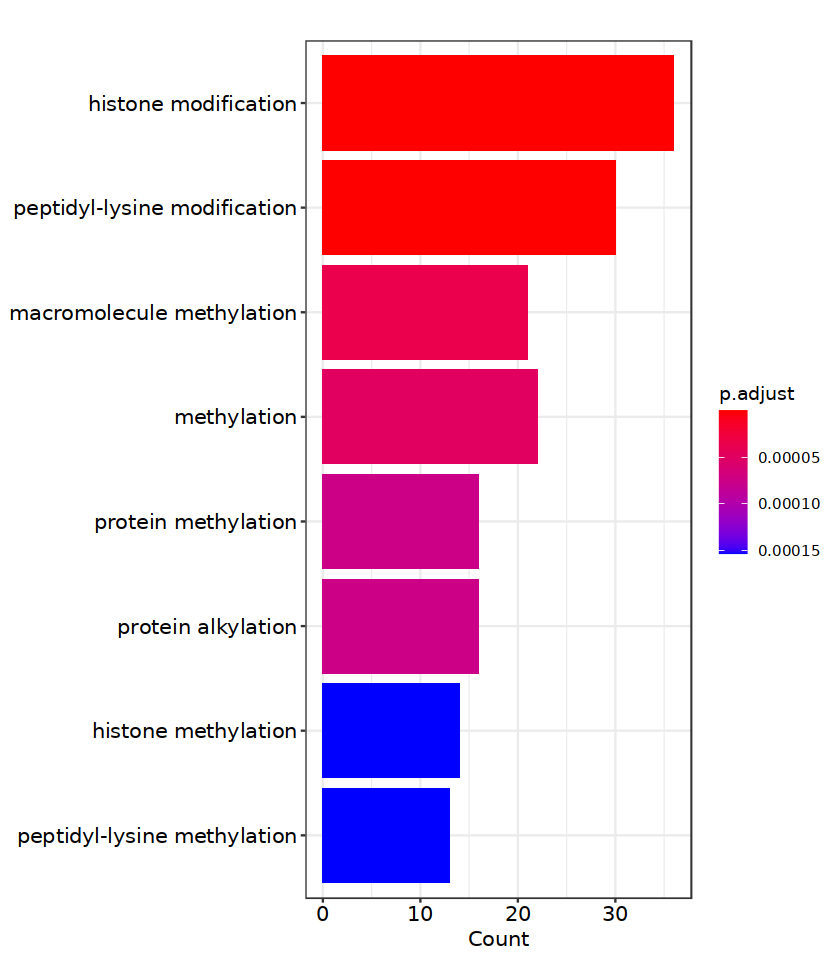

In [41]:
library(clusterProfiler)
library(org.Mm.eg.db)
rm(list = ls())
options(stringsAsFactors = F)
 
brown_hub_gene <- read.csv('brown_hub_gene.csv',header = F)
brown_hub_gene <- brown_hub_gene[-1,]
brown_hub_gene <- brown_hub_gene[,-1]
gene=unique(brown_hub_gene)
##基因转ID
sig_DP_entrezId <- mapIds(x = org.Mm.eg.db,
                             keys = gene,
                             keytype = "SYMBOL",
                             column = "ENTREZID")
table(is.na(sig_DP_entrezId))
sig_DP_entrezId <- na.omit(sig_DP_entrezId)
go_bp <- enrichGO(gene = sig_DP_entrezId,
                      OrgDb = org.Mm.eg.db,
                      keyType = "ENTREZID",
                      ont = "BP",
                      pvalueCutoff = 0.5,
                      qvalueCutoff = 0.5,
                      readable = TRUE)
#画图
barplot(go_bp)